# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [1]:
from google.colab import drive
#drive.mount('/content/drive')

#!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
#!unzip dataset.zip

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/ipvc/assignment1/dataset ./

Mounted at /content/drive


**Scenes' Image Processing**

In [2]:
import cv2
import matplotlib.pyplot as plt


In [3]:
scenes = ['dataset/scenes/scene1.png', 'dataset/scenes/scene2.png',
          'dataset/scenes/scene3.png', 'dataset/scenes/scene4.png',
          'dataset/scenes/scene5.png']

save succeded as: dataset/scenes/scene1.png.jpg


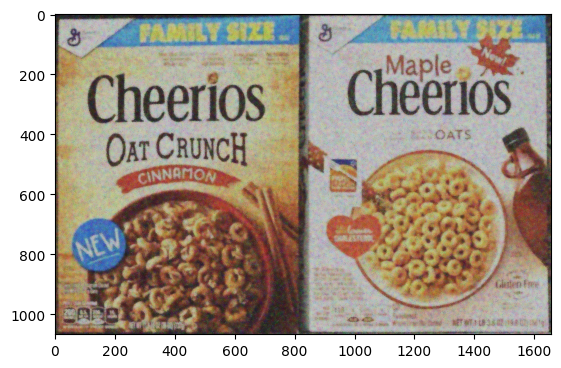

save succeded as: dataset/scenes/scene2.png.jpg


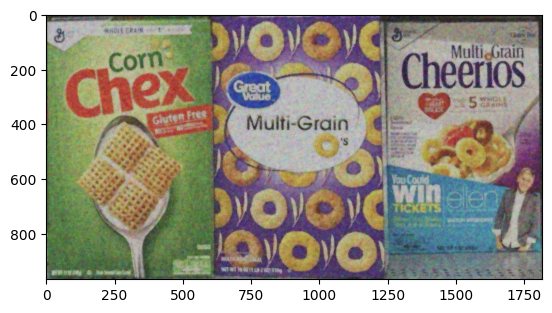

save succeded as: dataset/scenes/scene3.png.jpg


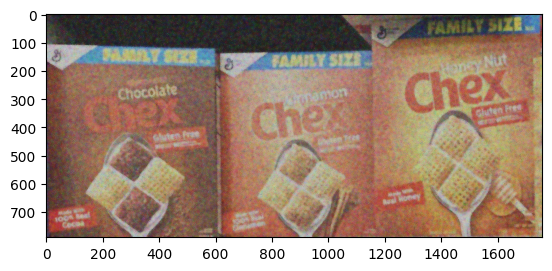

save succeded as: dataset/scenes/scene4.png.jpg


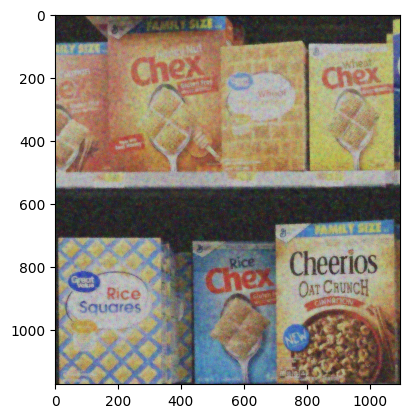

save succeded as: dataset/scenes/scene5.png.jpg


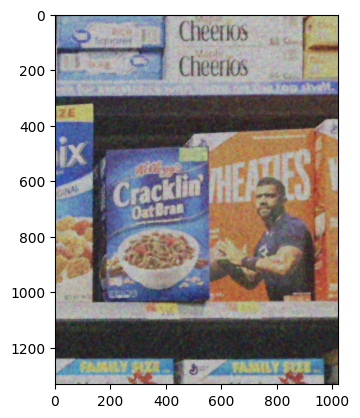

In [9]:
for scene in scenes:
  img = cv2.imread(scene)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  denoised_img = cv2.bilateralFilter(img_rgb, 15, 200, 100)
  name = scene + '.jpg'
  cv2.imwrite(name, cv2.cvtColor(denoised_img, cv2.COLOR_RGB2BGR))
  print(f"save succeded as: {name}")
  plt.imshow(denoised_img)
  plt.show()

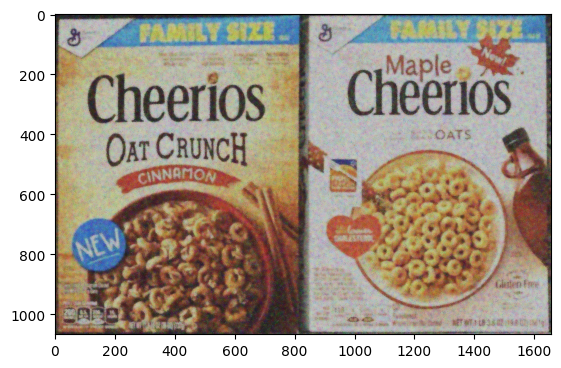

In [10]:
#trying on different filter, turns out didnt see much different yet

img = cv2.imread('dataset/scenes/scene1.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
denoised_img = cv2.bilateralFilter(img_rgb, 15, 200, 100)
plt.imshow(denoised_img)

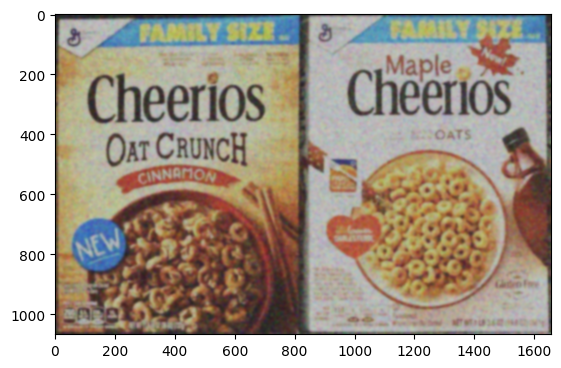

In [11]:
#another filter trial and error -> softer images

sigma = 3
k_size =  k_size = int(2 * 3 * sigma + 1)
gaussian_kernel_1D = cv2.getGaussianKernel(k_size, sigma)
gaussian_kernel_2D = gaussian_kernel_1D.dot(gaussian_kernel_1D.transpose())
img_tr2 = cv2.filter2D(denoised_img, -1, gaussian_kernel_2D)

plt.imshow(img_tr2)
plt.show()

**SINGLE TRACK - OBJECT DETECTION**

In [12]:
from pickle import TRUE
import numpy as np

def object_retrieve(img_query, img_train, min_match_count):
    sift = cv2.xfeatures2d.SIFT_create()
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    kp_query, des_query = sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train, kp_train)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_query,des_train,k=2)
    good = []
    for m,n in matches:
      if m.distance < 0.7*n.distance:
          good.append(m)

    if len(good) > min_match_count:
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        h, w, _ = img_query.shape
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)

        img_train_with_box = cv2.polylines(img_train, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

        # Display the scene image with both types of bounding boxes
        plt.imshow(img_train_with_box, 'gray', vmin=0, vmax=255)
        plt.title("Object Found")
        plt.show()
        return TRUE
    else:
      return 0



In [13]:
img_queries = ['dataset/models/ref1.png', 'dataset/models/ref2.png',
             'dataset/models/ref3.png', 'dataset/models/ref4.png',
             'dataset/models/ref5.png','dataset/models/ref6.png',
             'dataset/models/ref7.png', 'dataset/models/ref8.png',
             'dataset/models/ref9.png', 'dataset/models/ref10.png',
             'dataset/models/ref11.png', 'dataset/models/ref12.png',
             'dataset/models/ref13.png', 'dataset/models/ref14.png']
imgs_train = ['dataset/scenes/scene1.png.jpg', 'dataset/scenes/scene2.png.jpg',
              'dataset/scenes/scene3.png.jpg', 'dataset/scenes/scene4.png.jpg',
              'dataset/scenes/scene5.png.jpg']

In [14]:
import numpy as np
import matplotlib.pyplot as plt

Trial on Single Scene Image and Single Query Image

Height of bounding box: 1048.0
Width of bounding box: 802.0
Center position of bounding box: (412.0, 539.0)


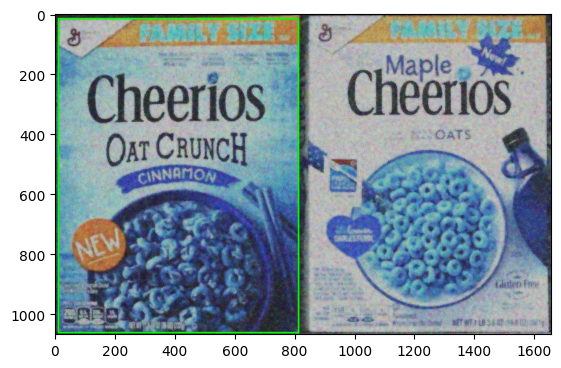

In [15]:
img_train = cv2.imread('dataset/scenes/scene1.png.jpg')
img_query = cv2.imread('dataset/models/ref1.png')

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descùriptors with SIFT
kp_query = sift.detect(img_query)
kp_train = sift.detect(img_train)

img=cv2.drawKeypoints(img_train, kp_train, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Describing keypoints for query and train images
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 50)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
matches = flann.knnMatch(des_query,des_train,k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# Checking if we found enough matching
MIN_MATCH_COUNT = 10

if len(good)>MIN_MATCH_COUNT:
    # building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    # Using RANSAC to estimate a robust homography.
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()

    # Corners of the query image
    h,w, _ = img_query.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts,M)

    # Drawing the bounding box
    img_train_p = cv2.polylines(img_train, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

    bounding_box_height = abs(dst[0][0][1] - dst[2][0][1])
    bounding_box_width = abs(dst[0][0][0] - dst[2][0][0])

    # Calculating center position of the bounding box
    center_position =((dst[0][0][0] + dst[2][0][0]) // 2),((dst[0][0][1] + dst[2][0][1]) // 2)

    # Printing information
    print(f'Height of bounding box: {round(bounding_box_height,0)}')
    print(f'Width of bounding box: {round(bounding_box_width, 0)}')
    print(f'Center position of bounding box: {center_position}')

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


plt.imshow(img_train_p, 'gray')
plt.show()


In [16]:
def object_detect(img_query, img_train, min_match_count):
  sift = cv2.xfeatures2d.SIFT_create()

  # find the keypoints and descùriptors with SIFT
  kp_query = sift.detect(img_query)
  kp_train = sift.detect(img_train)

  img=cv2.drawKeypoints(img_train, kp_train, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  # Describing keypoints for query and train images
  kp_query, des_query = sift.compute(img_query, kp_query)
  kp_train, des_train = sift.compute(img_train, kp_train)

  # Defining index for approximate kdtree algorithm
  FLANN_INDEX_KDTREE = 1

  # Defining parameters for algorithm
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

  # Defining search params.
  # checks=50 specifies the number of times the trees in the index should be recursively traversed.
  # Higher values gives better precision, but also takes more time
  search_params = dict(checks = 50)

  # Initializing matcher
  flann = cv2.FlannBasedMatcher(index_params, search_params)

  # Matching and finding the 2 closest elements for each query descriptor.
  matches = flann.knnMatch(des_query,des_train,k=2)

  good = []
  for m,n in matches:
      if m.distance < 0.7*n.distance:
          good.append(m)

  # Checking if we found enough matching
  MIN_MATCH_COUNT = 10

  if len(good)>MIN_MATCH_COUNT:
      # building the corrspondences arrays of good matches
      src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
      # Using RANSAC to estimate a robust homography.
      # It returns the homography M and a mask for the discarded points
      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

      # Mask of discarded point used in visualization
      matchesMask = mask.ravel().tolist()

      # Corners of the query image
      h,w, _ = img_query.shape
      pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

      # Projecting the corners into the train image
      dst = cv2.perspectiveTransform(pts,M)

      # Drawing the bounding box
      img_train_p = cv2.polylines(img_train, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

      bounding_box_height = abs(dst[0][0][1] - dst[2][0][1])
      bounding_box_width = abs(dst[0][0][0] - dst[2][0][0])

      # Calculating center position of the bounding box
      center_position =((dst[0][0][0] + dst[2][0][0]) // 2),((dst[0][0][1] + dst[2][0][1]) // 2)

      # Printing information
      print(f'Height of bounding box: {round(bounding_box_height,0)}')
      print(f'Width of bounding box: {round(bounding_box_width, 0)}')
      print(f'Center position of bounding box: {center_position}')

      return img_train_p, bounding_box_height, bounding_box_width, center_position

  else:
      print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
      matchesMask = None

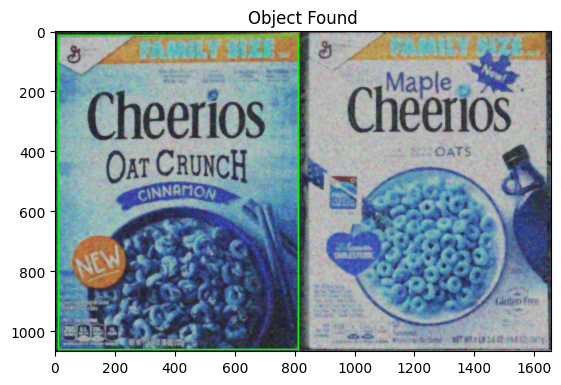

In [17]:
img_train = cv2.imread('dataset/scenes/scene1.png.jpg')
img_query = cv2.imread('dataset/models/ref1.png')

img_tr = object_retrieve(img_query, img_train, 50)

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def object_detect(img_query, img_train, min_match_count=70):
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp_query, des_query = sift.detectAndCompute(img_query, None)
    kp_train, des_train = sift.detectAndCompute(img_train, None)

    # Define parameters for the approximate nearest neighbor algorithm
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Initialize the Flann-based matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors of query and train images
    matches = flann.knnMatch(des_query, des_train, k=2)

    # Filter good matches using Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    # Check if enough good matches are found
    if len(good) > min_match_count:
        # Extract matched keypoints
        src_pts = np.float32([kp_query[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        # Find Homography matrix using RANSAC
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Get the bounding box corners of the query image
        h, w = img_query.shape[:2]
        query_corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

        # Project the query corners onto the train image using the homography matrix
        train_corners = cv2.perspectiveTransform(query_corners, M)

        # Draw the bounding box
        img_train_with_box = cv2.polylines(img_train, [np.int32(train_corners)], True, (0, 255, 0), 3, cv2.LINE_AA)

        # Calculate bounding box width, height, and center position
        bounding_box_height = abs(train_corners[0][0][1] - train_corners[2][0][1])
        bounding_box_width = abs(train_corners[0][0][0] - train_corners[2][0][0])
        center_position = ((train_corners[0][0][0] + train_corners[2][0][0]) / 2, (train_corners[0][0][1] + train_corners[2][0][1]) / 2)

        return img_train_with_box, bounding_box_height, bounding_box_width, center_position

    else:
        print(f"Not enough matches are found - {len(good)}/{min_match_count}")
        return None, None, None, None


Height of bounding box: 1048.22998046875
Width of bounding box: 802.0399780273438
Center position of bounding box: (412.22772216796875, 539.1561279296875)


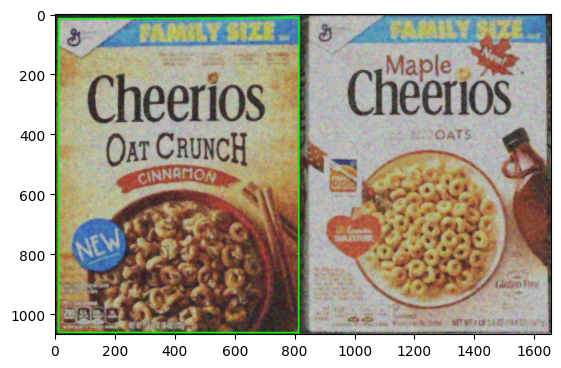

In [19]:
img_query = cv2.imread('dataset/models/ref1.png')
img_train = cv2.imread('dataset/scenes/scene1.png.jpg')

img_train_with_box, bounding_box_height, bounding_box_width, center_position = object_detect(img_query, img_train)

if img_train_with_box is not None:
    print(f'Height of bounding box: {round(bounding_box_height, 2)}')
    print(f'Width of bounding box: {round(bounding_box_width, 2)}')
    print(f'Center position of bounding box: {center_position}')

    plt.imshow(cv2.cvtColor(img_train_with_box, cv2.COLOR_BGR2RGB))
    plt.show()

**Trial on 1 Object for All Scenes Images**

Height of bounding box: 1048.0400390625
Width of bounding box: 801.8599853515625
Center position of bounding box: (412.15643310546875, 539.0997314453125)


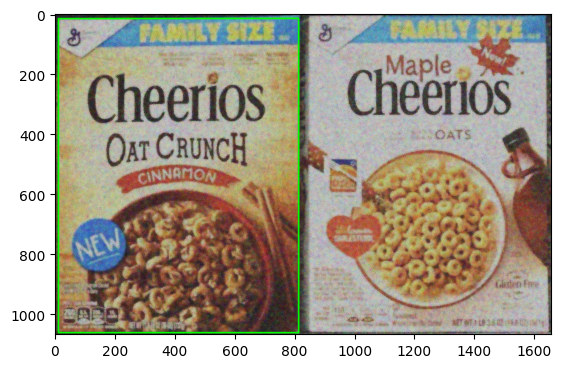

Not enough matches are found - 62/70
Not enough matches are found - 29/70
Height of bounding box: 501.2699890136719
Width of bounding box: 382.0799865722656
Center position of bounding box: (887.5195922851562, 915.1697998046875)


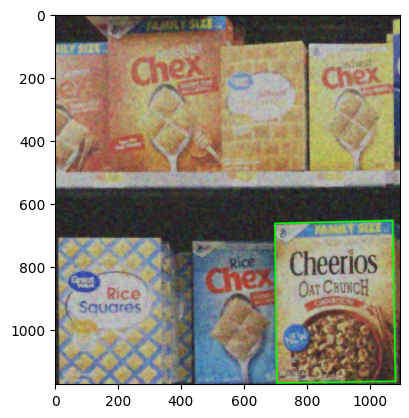

Not enough matches are found - 30/70


In [20]:
#trying to detect 1 object in all scenery
img_query = cv2.imread('dataset/models/ref1.png')
img_trains = ['dataset/scenes/scene1.png.jpg', 'dataset/scenes/scene2.png.jpg',
              'dataset/scenes/scene3.png.jpg', 'dataset/scenes/scene4.png.jpg',
              'dataset/scenes/scene5.png.jpg']


for img in img_trains:
  img_train = cv2.imread(img)
  img_train_with_box, bounding_box_height, bounding_box_width, center_position = object_detect(img_query, img_train)

  if img_train_with_box is not None:
      print(f'Height of bounding box: {round(bounding_box_height, 2)}')
      print(f'Width of bounding box: {round(bounding_box_width, 2)}')
      print(f'Center position of bounding box: {center_position}')

      plt.imshow(cv2.cvtColor(img_train_with_box, cv2.COLOR_BGR2RGB))
      plt.show()

**Trial on 1 Scene Image for All Object**

Not enough matches are found - 34/70
Not enough matches are found - 51/70
Not enough matches are found - 16/70
Not enough matches are found - 25/70
Not enough matches are found - 29/70
Not enough matches are found - 20/70
Not enough matches are found - 12/70
Not enough matches are found - 17/70
Not enough matches are found - 24/70
Not enough matches are found - 6/70
Height of bounding box: 551.47998046875
Width of bounding box: 368.6099853515625
Center position of bounding box: (368.8421630859375, 752.8919067382812)


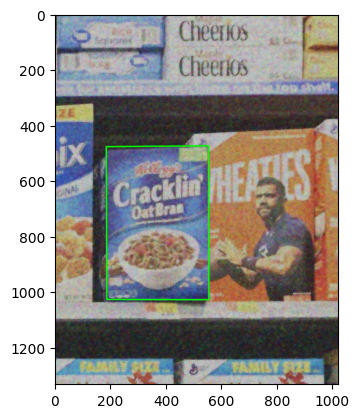

Height of bounding box: 646.239990234375
Width of bounding box: 424.82000732421875
Center position of bounding box: (714.3397216796875, 745.3129272460938)


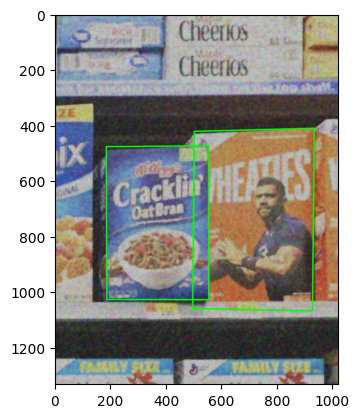

Not enough matches are found - 26/70
Not enough matches are found - 26/70


"\nI'm running on 5th scene image, and it shows us there are 2 objects: Cracklin and Wehaties, \nwhile the other subjects have no enough matches found on this scene image. \n"

In [21]:
#trying to detect 1 scenery through all object

#trying to detect 1 object in all scenery
img_queries = ['dataset/models/ref1.png', 'dataset/models/ref2.png',
             'dataset/models/ref3.png', 'dataset/models/ref4.png',
             'dataset/models/ref5.png','dataset/models/ref6.png',
             'dataset/models/ref7.png', 'dataset/models/ref8.png',
             'dataset/models/ref9.png', 'dataset/models/ref10.png',
             'dataset/models/ref11.png', 'dataset/models/ref12.png',
             'dataset/models/ref13.png', 'dataset/models/ref14.png']
img_train = cv2.imread('dataset/scenes/scene5.png.jpg')

for img in img_queries:
  img_query = cv2.imread(img)
  img_train_with_box, bounding_box_height, bounding_box_width, center_position = object_detect(img_query, img_train)

  if img_train_with_box is not None:
      print(f'Height of bounding box: {round(bounding_box_height, 2)}')
      print(f'Width of bounding box: {round(bounding_box_width, 2)}')
      print(f'Center position of bounding box: {center_position}')

      plt.imshow(cv2.cvtColor(img_train_with_box, cv2.COLOR_BGR2RGB))
      plt.show()

'''
I'm running on 5th scene image, and it shows us there are 2 objects: Cracklin and Wehaties,
while the other subjects have no enough matches found on this scene image.
'''

Not enough matches are found - 34/70
Not enough matches are found - 48/70
Not enough matches are found - 14/70
Not enough matches are found - 22/70
Not enough matches are found - 31/70
Not enough matches are found - 12/70
Not enough matches are found - 11/70
Not enough matches are found - 15/70
Not enough matches are found - 23/70
Not enough matches are found - 7/70
Not enough matches are found - 25/70
Not enough matches are found - 26/70


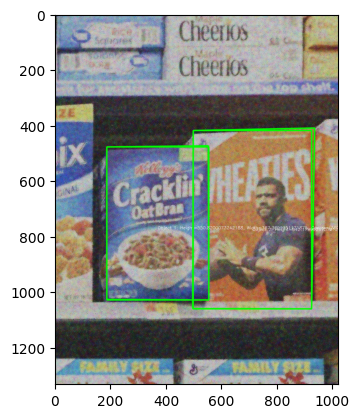

Object 1: Height=550.8200073242188, Width=367.3699951171875, Center=(369.8490295410156, 754.1624755859375)
Object 2: Height=642.1799926757812, Width=425.8399963378906, Center=(710.8810424804688, 740.5504150390625)


In [22]:
#Another method, with information of bouding box

img_queries = ['dataset/models/ref1.png', 'dataset/models/ref2.png',
               'dataset/models/ref3.png', 'dataset/models/ref4.png',
               'dataset/models/ref5.png', 'dataset/models/ref6.png',
               'dataset/models/ref7.png', 'dataset/models/ref8.png',
               'dataset/models/ref9.png', 'dataset/models/ref10.png',
               'dataset/models/ref11.png', 'dataset/models/ref12.png',
               'dataset/models/ref13.png', 'dataset/models/ref14.png']
img_train = cv2.imread('dataset/scenes/scene5.png.jpg')

# Initialize variables to store accumulated bounding box information
all_bounding_boxes = []
all_center_positions = []

# Count instances of each object
object_counts = {}

for img in img_queries:
    img_query = cv2.imread(img)
    img_train_with_box, bounding_box_height, bounding_box_width, center_position = object_detect(img_query, img_train)

    if img_train_with_box is not None:
        all_bounding_boxes.append((bounding_box_height, bounding_box_width))
        all_center_positions.append(center_position)

        # Count instances of each object
        object_counts.setdefault(len(all_bounding_boxes), 0)
        object_counts[len(all_bounding_boxes)] += 1

# Draw all bounding boxes on a single image
if all_bounding_boxes:
    img_with_boxes = img_train.copy()
    for i, ((bounding_box_height, bounding_box_width), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
        cv2.rectangle(img_with_boxes, (int(center_position[0] - bounding_box_width / 2),
                                       int(center_position[1] - bounding_box_height / 2)),
                      (int(center_position[0] + bounding_box_width / 2),
                       int(center_position[1] + bounding_box_height / 2)), (0, 255, 0), 3)
        text = f'Object {i}: Height={round(bounding_box_height, 2)}, Width={round(bounding_box_width, 2)}, Center={center_position}'
        cv2.putText(img_with_boxes, text, (int(center_position[0]), int(center_position[1] + 20 * i)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.show()

    for i, ((bounding_box_height, bounding_box_width), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
        print(f'Object {i}: Height={round(bounding_box_height, 2)}, Width={round(bounding_box_width, 2)}, Center={center_position}')


ANOTHER TRIAL

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def object_detect(img_query, img_train, min_match_count=80):
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp_query, des_query = sift.detectAndCompute(img_query, None)
    kp_train, des_train = sift.detectAndCompute(img_train, None)

    # Define parameters for the approximate nearest neighbor algorithm
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Initialize the Flann-based matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors of query and train images
    matches = flann.knnMatch(des_query, des_train, k=2)

    # Filter good matches using Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    # Check if enough good matches are found
    if len(good) > min_match_count:
        # Extract matched keypoints
        src_pts = np.float32([kp_query[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        # Find Homography matrix using RANSAC
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Get the bounding box corners of the query image
        h, w = img_query.shape[:2]
        query_corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

        # Project the query corners onto the train image using the homography matrix
        train_corners = cv2.perspectiveTransform(query_corners, M)

        # Draw the bounding box
        img_train_with_box = cv2.polylines(img_train, [np.int32(train_corners)], True, (0, 255, 0), 3, cv2.LINE_AA)

        # Calculate bounding box width, height, and center position
        bounding_box_height = abs(train_corners[0][0][1] - train_corners[2][0][1])
        bounding_box_width = abs(train_corners[0][0][0] - train_corners[2][0][0])
        center_position = ((train_corners[0][0][0] + train_corners[2][0][0]) / 2, (train_corners[0][0][1] + train_corners[2][0][1]) / 2)

        return img_train_with_box, bounding_box_height, bounding_box_width, center_position

    else:
        return None, None, None, None


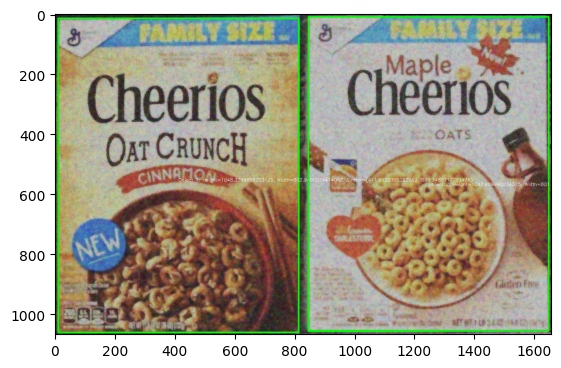

Object 1: 1 instance found, Height=1048.3399658203125, Width=802.9400024414062, Center=(411.6120300292969, 538.3485717773438)
Object 2: 1 instance found, Height=1047.489990234375, Width=801.77001953125, Center=(1247.321533203125, 533.1988525390625)


In [24]:
#trial on 1 scene image

img_queries = ['dataset/models/ref1.png', 'dataset/models/ref2.png',
               'dataset/models/ref3.png', 'dataset/models/ref4.png',
               'dataset/models/ref5.png', 'dataset/models/ref6.png',
               'dataset/models/ref7.png', 'dataset/models/ref8.png',
               'dataset/models/ref9.png', 'dataset/models/ref10.png',
               'dataset/models/ref11.png', 'dataset/models/ref12.png',
               'dataset/models/ref13.png', 'dataset/models/ref14.png']
img_train = cv2.imread('dataset/scenes/scene1.png.jpg')

# to store bounding box information
all_bounding_boxes = []
all_center_positions = []

# to count instances of each object
object_counts = {}

for img in img_queries:
    img_query = cv2.imread(img)
    img_train_with_box, bounding_box_height, bounding_box_width, center_position = object_detect(img_query, img_train)

    if img_train_with_box is not None:
        all_bounding_boxes.append((bounding_box_height, bounding_box_width))
        all_center_positions.append(center_position)

        object_counts.setdefault(len(all_bounding_boxes), 0)
        object_counts[len(all_bounding_boxes)] += 1

# Draw all bounding boxes on a single image
if all_bounding_boxes:
    img_with_boxes = img_train.copy()

    for i, ((bounding_box_height, bounding_box_width), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
        cv2.rectangle(img_with_boxes, (int(center_position[0] - bounding_box_width / 2),
                                       int(center_position[1] - bounding_box_height / 2)),
                      (int(center_position[0] + bounding_box_width / 2),
                       int(center_position[1] + bounding_box_height / 2)), (0, 255, 0), 3)

        text = f'Object {i}: Height={round(bounding_box_height, 2)}, Width={round(bounding_box_width, 2)}, Center={center_position}'
        cv2.putText(img_with_boxes, text, (int(center_position[0]), int(center_position[1] + 20 * i)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.show()


for i, ((bounding_box_height, bounding_box_width), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
    count_text = f"{object_counts[i]} instance{'s' if object_counts[i] > 1 else ''} found"
    print(f'Object {i}: {count_text}, Height={round(bounding_box_height, 2)}, Width={round(bounding_box_width, 2)}, Center={center_position}')


In [25]:
img_queries = ['dataset/models/ref1.png', 'dataset/models/ref2.png',
             'dataset/models/ref3.png', 'dataset/models/ref4.png',
             'dataset/models/ref5.png','dataset/models/ref6.png',
             'dataset/models/ref7.png', 'dataset/models/ref8.png',
             'dataset/models/ref9.png', 'dataset/models/ref10.png',
             'dataset/models/ref11.png', 'dataset/models/ref12.png',
             'dataset/models/ref13.png', 'dataset/models/ref14.png']
scene_images = ['dataset/scenes/scene1.png.jpg', 'dataset/scenes/scene2.png.jpg',
              'dataset/scenes/scene3.png.jpg', 'dataset/scenes/scene4.png.jpg',
              'dataset/scenes/scene5.png.jpg']

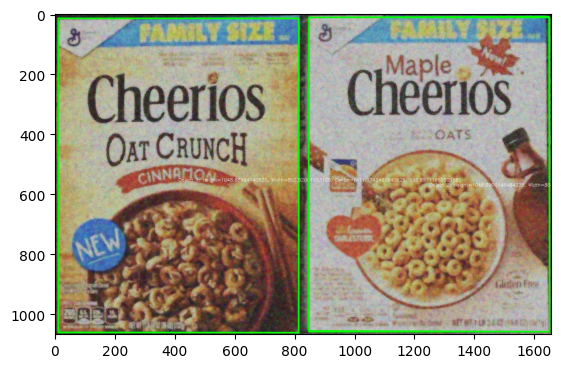

Object 1: 1 instance found, Height=1048.68994140625, Width=802.52001953125, Center=(411.9742431640625, 538.8571166992188)
Object 2: 1 instance found, Height=1048.8900146484375, Width=804.280029296875, Center=(1249.213134765625, 535.6326904296875)


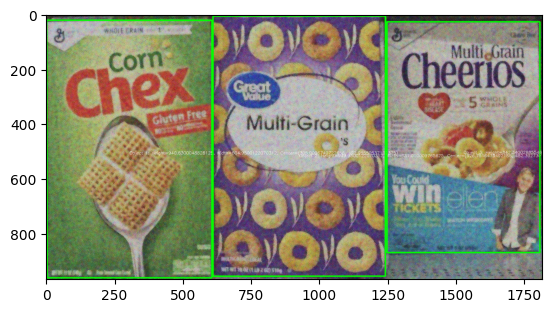

Object 1: 1 instance found, Height=940.6300048828125, Width=604.9500122070312, Center=(305.0096740722656, 492.95550537109375)
Object 2: 1 instance found, Height=949.9500122070312, Width=631.010009765625, Center=(926.7516479492188, 482.3927307128906)
Object 3: 1 instance found, Height=842.3400268554688, Width=560.3800048828125, Center=(1528.228515625, 450.0389099121094)


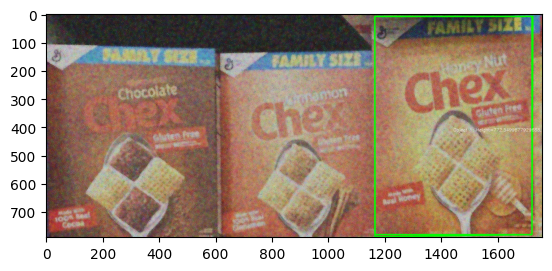

Object 1: 1 instance found, Height=772.5499877929688, Width=557.3599853515625, Center=(1443.72998046875, 395.0872802734375)


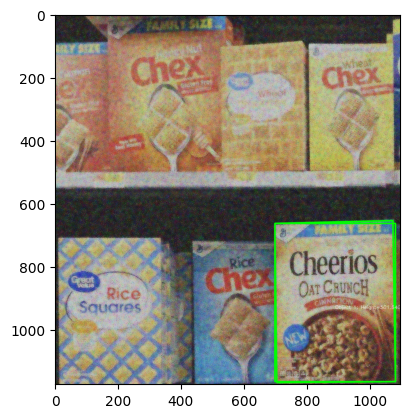

Object 1: 1 instance found, Height=501.6400146484375, Width=382.0899963378906, Center=(887.699951171875, 915.4928588867188)


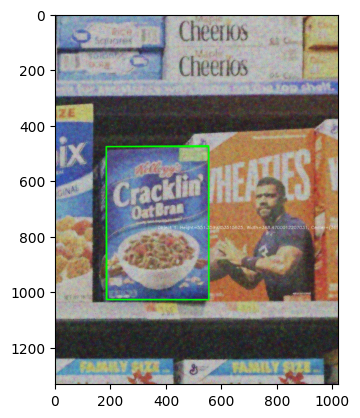

Object 1: 1 instance found, Height=551.3599853515625, Width=368.4700012207031, Center=(369.02886962890625, 753.1675415039062)


In [26]:
#trial on all scene image and all queries/object images

for scene_image in scene_images:
    img_train = cv2.imread(scene_image)

    # Initialize variables to store accumulated bounding box information
    all_bounding_boxes = []
    all_center_positions = []

    # Count instances of each object
    object_counts = {}

    for img in img_queries:
        img_query = cv2.imread(img)
        img_train_with_box, bounding_box_height, bounding_box_width, center_position = object_detect(img_query, img_train)

        if img_train_with_box is not None:
            all_bounding_boxes.append((bounding_box_height, bounding_box_width))
            all_center_positions.append(center_position)

            # Count instances of each object
            object_counts.setdefault(len(all_bounding_boxes), 0)
            object_counts[len(all_bounding_boxes)] += 1

    # Draw all bounding boxes on a single image
    if all_bounding_boxes:
        img_with_boxes = img_train.copy()
        for i, ((bounding_box_height, bounding_box_width), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
            cv2.rectangle(img_with_boxes, (int(center_position[0] - bounding_box_width / 2),
                                           int(center_position[1] - bounding_box_height / 2)),
                          (int(center_position[0] + bounding_box_width / 2),
                           int(center_position[1] + bounding_box_height / 2)), (0, 255, 0), 3)
            text = f'Object {i}: Height={round(bounding_box_height, 2)}, Width={round(bounding_box_width, 2)}, Center={center_position}'
            cv2.putText(img_with_boxes, text, (int(center_position[0]), int(center_position[1] + 20 * i)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
        plt.show()

    for i, ((bounding_box_height, bounding_box_width), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
        count_text = f"{object_counts[i]} instance{'s' if object_counts[i] > 1 else ''} found"
        print(f'Object {i}: {count_text}, Height={round(bounding_box_height, 2)}, Width={round(bounding_box_width, 2)}, Center={center_position}')

In [ ]:
'''
NOTES:
a. some objects are not getting well-detected - should fine-tune more on the filter for the scene images
b. convert the height and width to px
c. ensuring the label object (should the number of the objec speficially refers to certain object e.g. Cherios: object 1, heaties: object 2, etc)
d. adjust the output text template to be similar as examples from the tutor

'''